In [1]:
import numpy as np
import mmh3
import os
import pandas as pd
import matplotlib.pyplot as plt

## Functions for minhash

In [2]:
def shingle(aString, q, delimiter=' '):
    """
    Input:
        - aString (str): string to split into shingles
        - q (int)
        - delimiter (str): string of the delimiter to consider to split the input string (default: space)
    Return: list of unique shingles
    """
    
    all_shingles = []
    if delimiter != '':
        words_list = str(aString).split(delimiter)
    else:
        words_list = aString
    if len(words_list) < q:
        q = len(words_list)
    for i in range (len(words_list)-q+1):
        all_shingles.append(delimiter.join(words_list[i:i+q]))
    return list(set(all_shingles))

def listhash(l,seed):
    val = 0
    for e in l:
        val = val ^ mmh3.hash(e, seed)
    return val 

def minhash(shingles_list, seed):
    """
    Input:
        - shingles_list (list of str): set of hashes
        - seed (int): seed for listhash function
    Return: minhash of given shingles
    """
    minhash_value = np.inf
    for aShingle in shingles_list:
        hashcode = listhash([aShingle], seed)
        if minhash_value == None or hashcode < minhash_value:
            minhash_value = hashcode
    return minhash_value

def minhash2(shingles_list, k):
    """
    Input:
        - shingles_list (list of str): set of hashes
        - k (int): seed for listhash function
    Return: sequence of k minhashes
    """
    all_minhash = []
    for i in range(k):
        all_minhash.append(minhash(shingles_list, i))
    return all_minhash

def signature(df_reviews, q = 3, num_hashes = 100):
    """
    Input:
        - dict_docs (dict of str:str): dictionary of {title:document}
        - q (int)
        - num_hashes (int)
    Return: dictionary consisting of document idâ€™s as keys and signatures as values
    """
    dict_signatures = {}
    total_texts = len(df_reviews.index)
    counter = 1
    for ix, text in enumerate(df_reviews['Clean_Review']):
        #print(f'{counter}/{total_texts} - {ix} - Processing...')
        doc_shingles = shingle(text, q)
        minhash_values = minhash2(doc_shingles, num_hashes)
        dict_signatures[ix] = minhash_values
        counter += 1
    return dict_signatures

def jaccard(name1, name2, signatures_dict):
    """
    Input:
        - name1 (str): key of the first document S
        - name2 (str): key of the second document T
        - signatures_dict (dict of str:list): dictionary of signatures
    Return: Jaccard similarity between S and T
    """
    signatures_doc1 = np.array(signatures_dict[name1])
    signatures_doc2 = np.array(signatures_dict[name2])
    return len(np.intersect1d(signatures_doc1, signatures_doc2))/len(np.union1d(signatures_doc1, signatures_doc2))

def lsh(signatures_dict, jaccard_threshold=0.6, seed=42):
    lsh_dict = {}
    for key, values in signatures_dict.items():
        blocks = np.split(np.array(values), b)
        blocks_hash_values = []
        for aBlock in blocks:
            blocks_hash_values.append(mmh3.hash(aBlock, seed))
        lsh_dict[key] = blocks_hash_values
    list_keys = list(lsh_dict.keys())
    similar_items = {}
    for i in range (len(list_keys)-1):
        print(i)
        for j in range (i+1, len(list_keys)):
            common_values = np.intersect1d(lsh_dict[list_keys[i]], lsh_dict[list_keys[j]])
            if len(common_values) > 0:
                # we found a candidate
                similarity_score = jaccard(list_keys[i], list_keys[j], signatures_dict)
                if similarity_score >= jaccard_threshold:
                    similar_items[(list_keys[i], list_keys[j])] = similarity_score
                    #print((list_keys[i], list_keys[j]))
                    #print(similar_items[(list_keys[i], list_keys[j])])
    return similar_items

## Import data

In [3]:
root = os.getcwd()
df = pd.read_csv(root + "\clean_sample_data.csv")

In [4]:
df.head()

,overall,reviewText,Clean_Review
0,1.0,I have been involved with computers for 22 yea...,involve computer year expert design program co...
1,1.0,Downloaded KIS7 because previous subscription ...,download previous subscription expire load say...
2,1.0,Norton Security has been working fine for the ...,norton security work fine last year start use ...
3,1.0,same ol' same ol' from Microsoft - but what ca...,ol ol microsoft expect company large dysfuncti...
4,1.0,I have been using Quicken since the 2nd DOS ve...,use quicken since do version cannot understand...


## Create minhash signatures for each review

In [5]:
k = 100
b,r = 10, 10
assert k == b*r

sigs = signature(df, q = 1, num_hashes = k)

# sim_items = lsh(sigs)


## Clustering based on minhash signatures

In [6]:
def dic_to_vec(dic):
    """
    Create matrix of signatures usable by sklearn.
    
    args:
        dic: Dictionary of review signatures
    returns:
        numpy matrix of dimensions (# of reviews, # of minhashes)
    """
    for ix, sig in enumerate(list(dic.items())):
        if ix == 0:
            X = np.array([sig[1]])
        else:
            X = np.append(X,[sig[1]],axis=0)
    return X

In [7]:
X = dic_to_vec(sigs)

In [8]:
y = np.array(df.overall.values)

## KMeans clustering

In [9]:
from sklearn.cluster import KMeans
#from sklearn.cluster import BisectingKMeans

In [10]:
# Initialize classifier
k_means = KMeans(n_clusters=5, random_state=0)

In [11]:
X_transform = k_means.fit_transform(X,y)

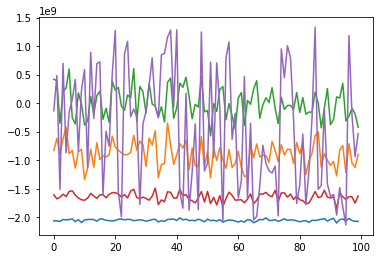

In [12]:
centroids = k_means.cluster_centers_

plt.plot(centroids.T)

In [13]:
def assign_cluster(centroid_list, dic):
    """
    Assigns each review to a cluster.
    
    Args:
        centroid_list: List of centroids in their vector format.
        dic: Dictionary of signatures of reviews.
    Returns:
        assignments: Dictionary of reviews and their cluster.
    """
    assignments = {}
    for ix, sig in enumerate(list(dic.items())):
        distances = []
        for j, centroid in enumerate(centroid_list):
            distances.append(np.linalg.norm(centroid-sig[1]))
        assignments[ix] = np.argmin(distances)
    return assignments

In [14]:
assigned = assign_cluster(centroids, sigs)

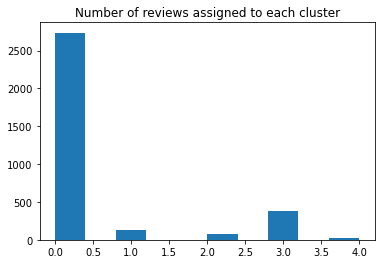

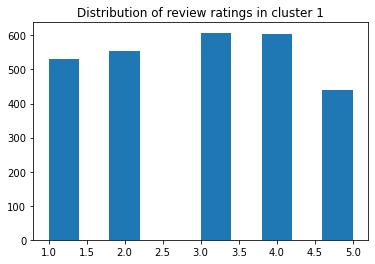

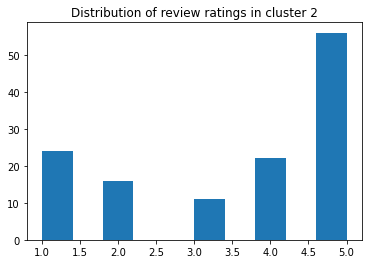

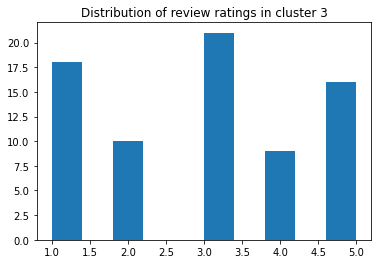

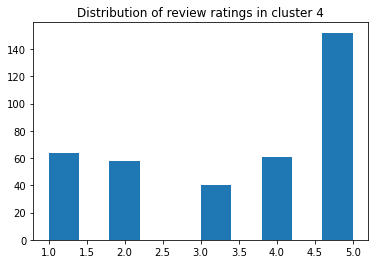

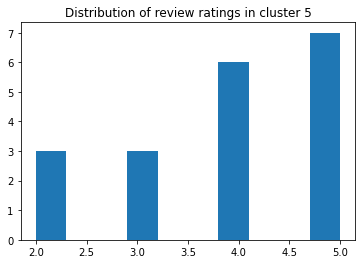

In [15]:
plt.hist(list(assigned.values()))
plt.title("Number of reviews assigned to each cluster")
plt.show()
for i in range(len(centroids)):
    df_slice = df.loc[pd.Series(list(assigned.values())) == i]
    #print(df_slice)
    #review_lengths = [len(df_slice.Clean_Review.values[i]) for i in range(len(df_slice.Clean_Review.values))]
    plt.hist(df_slice['overall'])
    plt.title(str("Distribution of review ratings in cluster "+ str(i+1)))
    plt.show()
    #plt.hist(review_lengths)
    #plt.show()

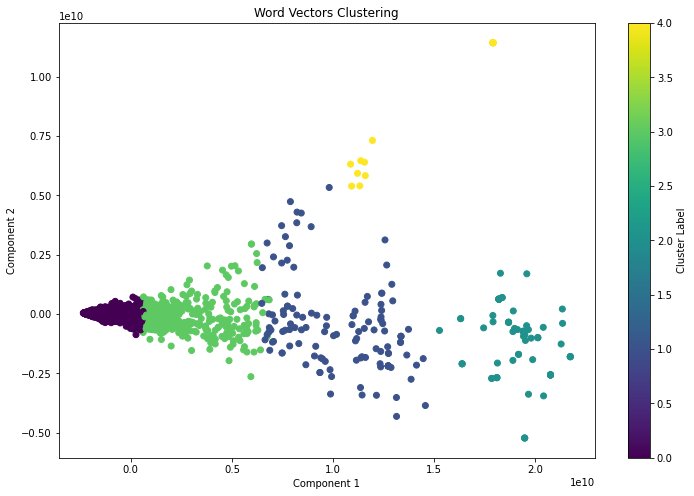

In [16]:
from sklearn.decomposition import PCA

labels = k_means.labels_

pca = PCA(n_components=4)
reduced_X = pca.fit_transform(X)
plt.figure(figsize=(12, 8))
plt.scatter(reduced_X[:, 0], reduced_X[:, 1], c=labels, cmap='viridis', marker='o')
plt.title('Word Vectors Clustering')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.colorbar(label='Cluster Label')
plt.show()


## Defining basic tf_idf function

In [30]:
from collections import Counter

def get_word_usage(documents, n_t = None, min_appearances = 1):
    """ Called by tf_idf.
    Get number of document appearances for all words: """ 
    document_appearances = {}
    
    N = len(documents)
    
    for i in range(N):
        text = str(documents[i]).split(" ")
        unique_words = np.unique(text)
        for word in unique_words:
            if not(n_t is None) and n_t[word] < min_appearances:
                # If the word does not appear in enough documents to
                # be significant for the cluster in general.
                continue
            elif word not in document_appearances.keys():
                document_appearances[word] = 1
            else:
                document_appearances[word] = document_appearances[word] + 1
    return document_appearances, N

def calc_tf_idf(documents, N, n_t):
    tf_idf_sparse = []
    for i in range(N):
        text = str(documents[i]).split(" ")
        word_freq = Counter(text)
        max_freq = max(word_freq.values())
        
        tf_idf_vector = np.zeros(len(n_t))
        
        for word in word_freq.items():
            if word[0] in n_t.keys():
                index = list(n_t).index(word[0])    
                tf_idf_vector[index] = word[1]/max_freq*np.log2(N/n_t[word[0]])
        
        tf_idf_sparse.append(tf_idf_vector)

    return np.asarray(tf_idf_sparse)


def get_tf_idf(df_docs):
    documents = np.array(df_docs.Clean_Review.values)
    
    n_t, N = get_word_usage(documents)

    tf_idf_sparse_matrix = calc_tf_idf(documents, N, n_t)
    
    return tf_idf_sparse_matrix, np.asarray(list(n_t.keys()))

In [18]:
tf_idf, features = get_tf_idf(df)

In [19]:
print(len(features))

12816


## TF_IDF for clusters

In [117]:
def merge_reviews(df, assignments):
    """ Collect all text from reviews in each cluster into a single string """
    assignments = np.asarray(list(assignments.values()))
    clusters = np.unique(assignments)
    documents = []
    for i in clusters:
        cluster_reviews = df.loc[assignments == i,"Clean_Review"].values
        all_text = str(cluster_reviews[0])
        for j in range(1, len(cluster_reviews)):
            all_text += " " + str(cluster_reviews[j])
        documents.append(all_text)
    
    return np.asarray(documents,str)

def get_tf_idf_cluster(df_docs, assignments, min_appearances = 1):
    documents = np.array(df_docs.Clean_Review.values)
    
    n_t_reviews, N = get_word_usage(documents)
    
    merged_documents = merge_reviews(df_docs, assignments)
    
    n_t_cluster, N = get_word_usage(merged_documents, n_t = n_t_reviews, min_appearances = min_appearances)
    
    tf_idf_sparse_matrix_clusters = calc_tf_idf(merged_documents, N, n_t_cluster)
    
    
    tf_idf_sparse_matrix = calc_tf_idf(documents, len(documents), n_t_cluster)
    
    # Weight the words from each cluster based on their tf_idf in the cluster
    tf_idf_sparse_matrix = tf_idf_sparse_matrix
    
    return tf_idf_sparse_matrix, tf_idf_sparse_matrix_clusters, n_t_cluster, n_t_reviews


def find_n_largest_tfidf(tf_idf,n=5):
    largest_tfidf = {}
    for key in tf_idf:
        word_dict = tf_idf[key]
        words = np.asarray(list(word_dict.keys()))
        values = np.asarray(list(word_dict.values()))
        sort_values = np.argsort(values)[-n:][::-1]
        high_tf_idf = {}
        for i in sort_values:
            high_tf_idf[words[i]] = word_dict[words[i]]
        largest_tfidf[key] = high_tf_idf
    return largest_tfidf


In [109]:

def something():
    weights = (tf_idf_sparse_matrix).max(axis=0)

    documents = np.array(df_docs.Clean_Review.values)

    N = len(documents)

    tf_idf_sparse_matrix = []
    for i in range(N):
        text = str(documents[i]).split(" ")
        text_length = len(text)
        word_freq = Counter(text)
        max_freq = max(word_freq.values())
        tf_idf_vector = np.zeros(len(all_words))  

        for word in feature_words:
            if word in word_freq.keys():
                index = list(feature_words).index(word)
                tf_idf_vector[index] = weights[index]
        tf_idf_sparse_matrix.append(tf_idf_vector)
    tf_idf_sparse_matrix = np.asarray(tf_idf_sparse_matrix)
    
    return tf_idf, tf_idf_sparse_matrix, all_words

In [22]:
find_n_largest_tfidf(tf_idf_clusters, n=5)

NameError: name 'tf_idf_clusters' is not defined

## Supervised learning with tf_idf


In [110]:
df_neg = df.loc[(df['overall']<1.5) | (df['overall']>4.5)]
df_neu = df.loc[df['overall']==3]
df_pos = df.loc[df['overall']>3.5]

In [111]:
df_neg.index

Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
            ...
            3323, 3324, 3325, 3326, 3327, 3328, 3329, 3330, 3331, 3332],
           dtype='int64', length=1308)

In [118]:
assignments = {}
for i in df_neg.index:
    rating = df_neg['overall'][i]
    #assignments[i] = (-1 if rating < 2.5 else (1 if rating > 3.5 else 0))
    assignments[i] = (-1 if rating < 2.5 else 1)

In [120]:
tf_idf, tf_idf_clusters, features, all_words = get_tf_idf_cluster(df_neg, assignments, min_appearances = 2)

In [145]:
neg_tf_idf = -tf_idf*1000*tf_idf_clusters[0]
pos_tf_idf = tf_idf*1000*tf_idf_clusters[1]
tf_idf = neg_tf_idf+pos_tf_idf


In [146]:
tf_idf.shape

(1308, 4126)

## Clustering based on the tf-idf sparse matrix

In [149]:
X_train = tf_idf.sum(axis=1)

In [150]:
print(X_train.shape)

(1308,)


In [151]:
import scipy

X_train = scipy.sparse.csr_matrix(X_train)

In [152]:
X_train.T*X_train

<1308x1308 sparse matrix of type '<class 'numpy.float64'>'
	with 662596 stored elements in Compressed Sparse Column format>

In [162]:
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
from sklearn.decomposition import TruncatedSVD

#pca = TruncatedSVD(n_components=3)
#reduced_X = pca.fit_transform(X_train)

kmeans = KMeans(n_clusters=2, random_state=0, init = "k-means++") #, n_init = 'auto')

df_neg.overall.loc[df_neg.overall.values == 1] = 0
df_neg.overall.loc[df_neg.overall.values == 5] = 1
y_train = np.asarray(df_neg.overall.values)

kmeans.fit(X_train.T)

y_pred_train = kmeans.labels_+1
y_pred_train = kmeans.predict(X_train.T)

acc = accuracy_score(y_train, y_pred_train)
print("Accuracy: ",acc)

Accuracy:  0.4847094801223242


C:\Users\Frede\anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [163]:
y_pred_train.mean()

0.0015290519877675841

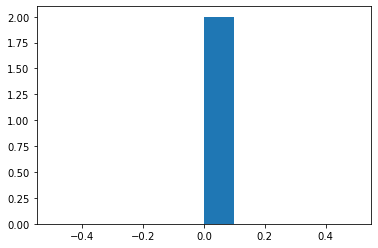

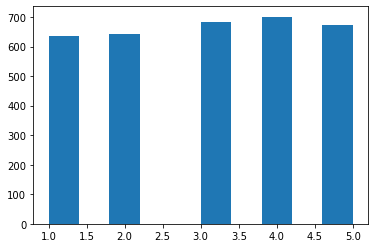

In [164]:
plt.hist(df_neg.loc[y_pred_train == 1]['overall'])
plt.show()
plt.hist(df['overall'])
plt.show()


In [54]:
plt.barplot(y_pred_train, bins = 3)

AttributeError: module 'matplotlib.pyplot' has no attribute 'barplot'

In [ ]:
true_freq = Counter(y_train)
pred_freq = Counter(y_pred_train)
true_x = list(true_freq.keys())-0.1*np.ones(len(true_freq))
pred_x = list(pred_freq.keys())+0.1*np.ones(len(pred_freq))

plt.bar(true_x, true_freq.values(), width=0.2, label="True")
plt.bar(pred_x, list(pred_freq.values()), width=0.2, label="Pred")
plt.legend()
plt.show()

In [325]:
df.loc[y_pred_train == 2,'Clean_Review'].values

array(['involve computer year expert design program computer ton experience use computer world even think go online without protection virus long time user trend line product nothing best result use virus protection firewall protect threat trend micro bring new version program jump right feel need research product since trust company soon instal program regret firewall protection company say program enhances firewall available window operate system yet refuse give detail also many user trouble lose file get program allow know website recognize program version software give user less protection next control program decide want junk protecting attempt roll back old version program hour ordeal try get software uninstall windows uninstall program could get rid next try download uninstall tool directly trend micro work either purchase copy old version program right amazon since trend micro offer site copy force uninstall tool cd finally clean new version line stay far away program want best

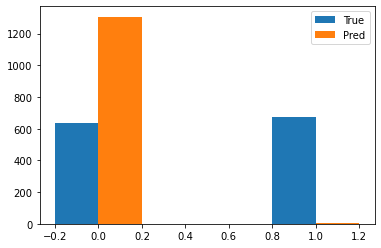

In [165]:
from collections import Counter



true_freq = Counter(y_train)
pred_freq = Counter(y_pred_train)
true_x = list(true_freq.keys())-0.1*np.ones(len(true_freq))
pred_x = list(pred_freq.keys())+0.1*np.ones(len(pred_freq))

plt.bar(true_x, true_freq.values(), width=0.2, label="True")
plt.bar(pred_x, list(pred_freq.values()), width=0.2, label="Pred")
plt.legend()
plt.show()